## Stock Price Prediction

### 1. Importing library

In [1]:
import pandas as pd
import numpy as np
import datetime
import math
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tools.eval_measures import rmse
from pmdarima.arima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from pmdarima.arima import auto_arima



import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/macbook/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### 2. Reading in text data for sentiment analysis

In [2]:
textdf = pd.read_csv('abcnews-date-text.csv')
textdf

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers
...,...,...
1244179,20211231,two aged care residents die as state records 2...
1244180,20211231,victoria records 5;919 new cases and seven deaths
1244181,20211231,wa delays adopting new close contact definition
1244182,20211231,western ringtail possums found badly dehydrate...


In [3]:
textdf.dtypes

publish_date      int64
headline_text    object
dtype: object

In [4]:
textdf.shape

(1244184, 2)

In [5]:
textdf.columns = ['date', 'headline']

In [6]:
textdf

,date,headline
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers
...,...,...
1244179,20211231,two aged care residents die as state records 2...
1244180,20211231,victoria records 5;919 new cases and seven deaths
1244181,20211231,wa delays adopting new close contact definition
1244182,20211231,western ringtail possums found badly dehydrate...


In [7]:
textdf['date'] = pd.to_datetime(textdf['date'], format='%Y%m%d')

In [8]:
textdf.head()

,date,headline
0,2003-02-19,aba decides against community broadcasting lic...
1,2003-02-19,act fire witnesses must be aware of defamation
2,2003-02-19,a g calls for infrastructure protection summit
3,2003-02-19,air nz staff in aust strike for pay rise
4,2003-02-19,air nz strike to affect australian travellers


In [9]:
vader = SentimentIntensityAnalyzer()
f = lambda headline: vader.polarity_scores(headline)['compound']

In [10]:
textdf['compound_score'] = textdf['headline'].apply(f)

In [11]:
textdf.head()

,date,headline,compound_score
0,2003-02-19,aba decides against community broadcasting lic...,0.0000
1,2003-02-19,act fire witnesses must be aware of defamation,-0.3400
2,2003-02-19,a g calls for infrastructure protection summit,0.0000
3,2003-02-19,air nz staff in aust strike for pay rise,-0.2263
4,2003-02-19,air nz strike to affect australian travellers,-0.1280


In [12]:
mean_score = textdf.groupby(['date']).mean()

In [13]:
mean_score.tail()

,compound_score
date,
2021-12-27,-0.114184
2021-12-28,-0.052474
2021-12-29,0.006050
2021-12-30,0.016529
2021-12-31,0.008130


In [14]:
mean_score.to_csv('MeanScore.csv')

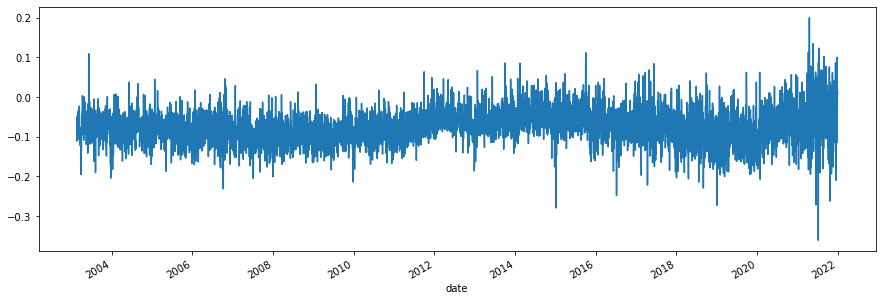

In [15]:
mean_score['compound_score'].plot(style='-', figsize=(15, 5))
plt.show()

In [16]:
score_chart = mean_score.copy()

In [17]:
score_chart['day'] = score_chart.index.dayofweek
score_chart['quarter'] = score_chart.index.quarter
score_chart['month'] = score_chart.index.month
score_chart['year'] = score_chart.index.year

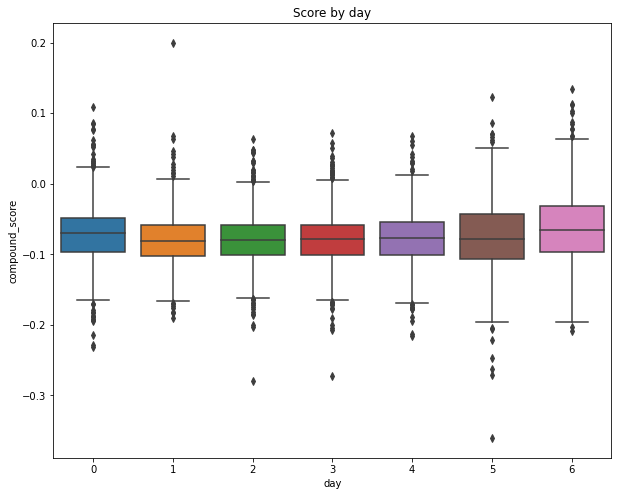

In [18]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=score_chart, x='day', y='compound_score')
ax.set_title('Score by day')
plt.savefig('ScoreByDay')
plt.show()
#Monday:0 - Sunday:6

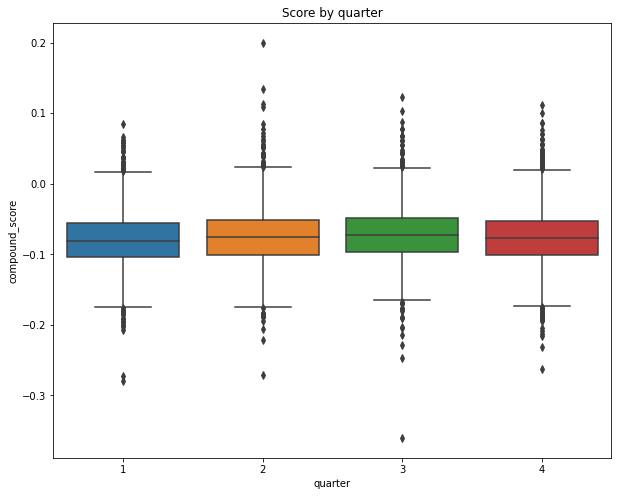

In [19]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=score_chart, x='quarter', y='compound_score')
ax.set_title('Score by quarter')
plt.savefig('ScoreByQuarter')
plt.show()

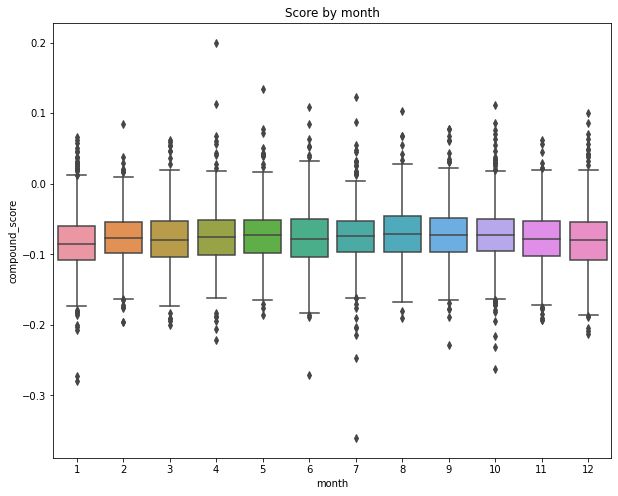

In [20]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=score_chart, x='month', y='compound_score')
ax.set_title('Score by month')
plt.savefig('ScoreByMonth')
plt.show()

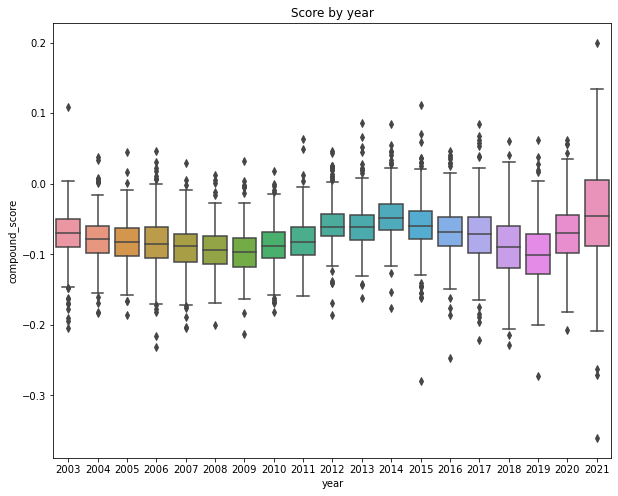

In [21]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=score_chart, x='year', y='compound_score')
ax.set_title('Score by year')
plt.savefig('ScoreByYear')
plt.show()

### 3. Reading in stock data for stock analysis

In [22]:
azn = pd.read_csv('AZN.csv')

In [23]:
azn.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
4746,2021-12-23,57.500000,57.910000,57.360001,57.639999,56.304501,3473600
4747,2021-12-27,57.619999,58.070000,57.529999,58.060001,56.714771,2170800
4748,2021-12-28,58.060001,58.490002,58.060001,58.320000,56.968746,2188700
4749,2021-12-29,58.459999,58.689999,58.310001,58.650002,57.291100,2716500
4750,2021-12-30,58.529999,58.880001,58.340000,58.470001,57.115269,2183700


In [24]:
azn.columns = azn.columns.str.lower()

In [25]:
azn['date'] = pd.to_datetime(azn['date'])

In [26]:
azn.index = azn.pop('date')

In [27]:
azn['movement'] = azn['close'] - azn['open']

In [28]:
azn

,open,high,low,close,adj close,volume,movement
date,,,,,,,
2003-02-19,17.350000,17.350000,17.049999,17.205000,8.077115,1593400,-0.145000
2003-02-20,17.225000,17.275000,16.995001,17.219999,8.084159,919000,-0.005001
2003-02-21,17.225000,17.424999,16.850000,17.215000,8.081808,1477800,-0.010000
2003-02-24,16.975000,17.055000,16.594999,16.625000,7.804826,1714200,-0.350000
2003-02-25,16.375000,16.500000,16.065001,16.450001,7.722671,2157800,0.075001
...,...,...,...,...,...,...,...
2021-12-23,57.500000,57.910000,57.360001,57.639999,56.304501,3473600,0.139999
2021-12-27,57.619999,58.070000,57.529999,58.060001,56.714771,2170800,0.440002
2021-12-28,58.060001,58.490002,58.060001,58.320000,56.968746,2188700,0.259999


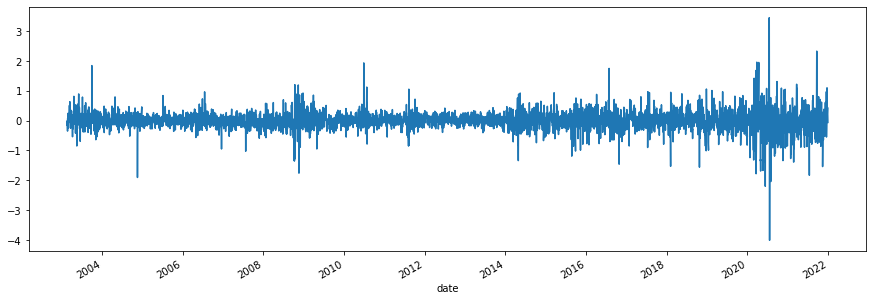

In [29]:
azn['movement'].plot(style='-', figsize=(15, 5))
plt.show()

In [30]:
azn['movement'].to_csv('AZNMovement.csv')

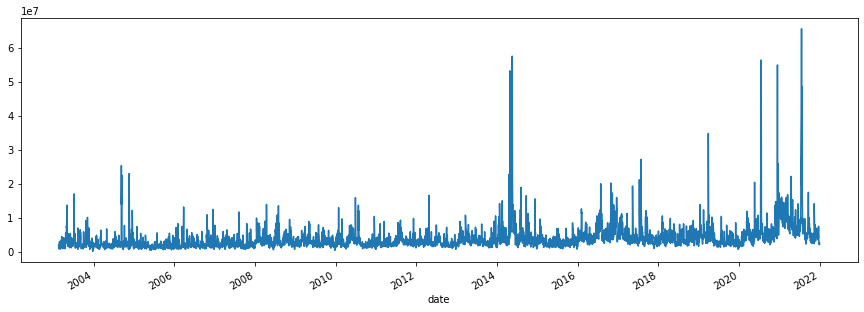

In [31]:
azn['volume'].plot(style='-', figsize=(15, 5))
plt.show()

In [32]:
azn['volume'].to_csv('AZNVolume.csv')

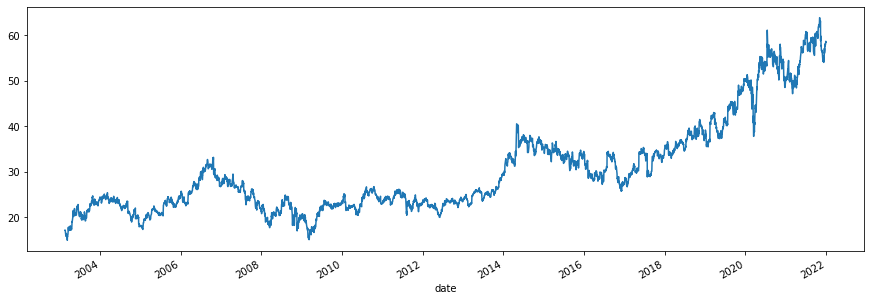

In [33]:
azn['close'].plot(style='-', figsize=(15, 5))
plt.show()

In [34]:
azn['close'].to_csv('AZNClosePrice.csv')

In [35]:
trend = azn.copy()

In [36]:
trend = trend.copy()
trend['dayofweek'] = trend.index.dayofweek
trend['quarter'] = trend.index.quarter
trend['month'] = trend.index.month
trend['year'] = trend.index.year

In [37]:
trend

,open,high,low,close,adj close,volume,movement,dayofweek,quarter,month,year
date,,,,,,,,,,,
2003-02-19,17.350000,17.350000,17.049999,17.205000,8.077115,1593400,-0.145000,2,1,2,2003
2003-02-20,17.225000,17.275000,16.995001,17.219999,8.084159,919000,-0.005001,3,1,2,2003
2003-02-21,17.225000,17.424999,16.850000,17.215000,8.081808,1477800,-0.010000,4,1,2,2003
2003-02-24,16.975000,17.055000,16.594999,16.625000,7.804826,1714200,-0.350000,0,1,2,2003
2003-02-25,16.375000,16.500000,16.065001,16.450001,7.722671,2157800,0.075001,1,1,2,2003
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,57.500000,57.910000,57.360001,57.639999,56.304501,3473600,0.139999,3,4,12,2021
2021-12-27,57.619999,58.070000,57.529999,58.060001,56.714771,2170800,0.440002,0,4,12,2021
2021-12-28,58.060001,58.490002,58.060001,58.320000,56.968746,2188700,0.259999,1,4,12,2021


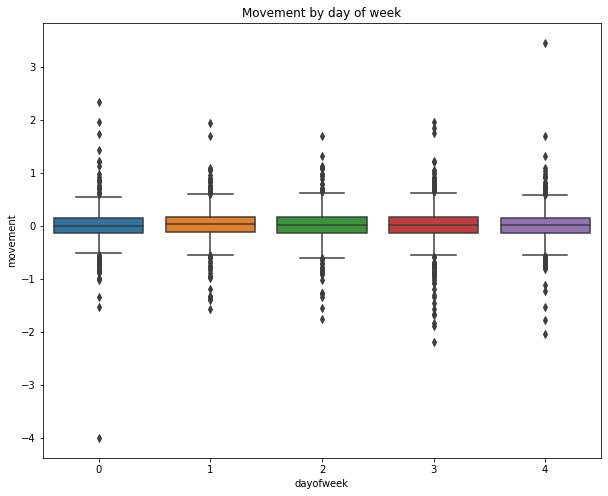

In [38]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=trend, x='dayofweek', y='movement')
ax.set_title('Movement by day of week')
plt.savefig('AZNMovementByDay')
plt.show()

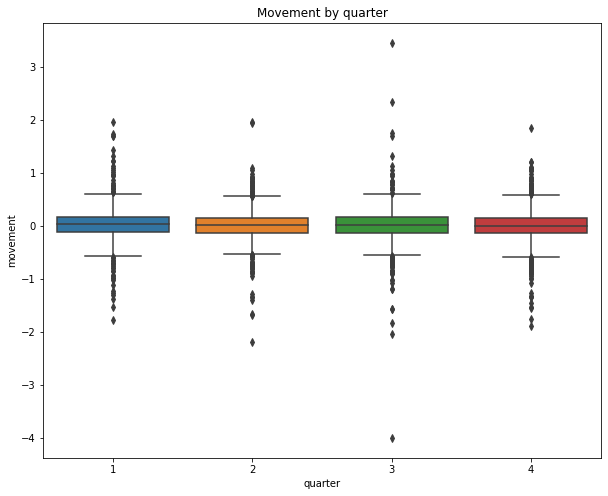

In [39]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=trend, x='quarter', y='movement')
ax.set_title('Movement by quarter')
plt.savefig('AZNMovementByQuarter')
plt.show()

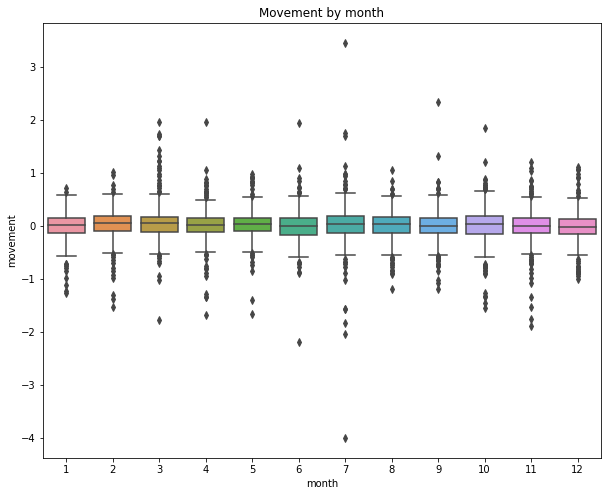

In [40]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=trend, x='month', y='movement')
ax.set_title('Movement by month')
plt.savefig('AZNMovementByMonth')
plt.show()

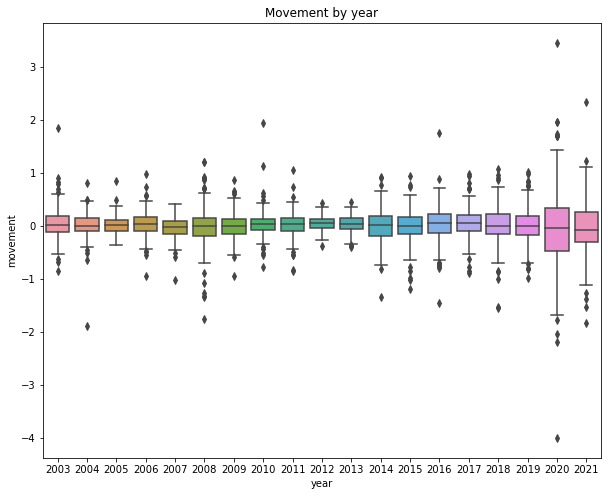

In [41]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=trend, x='year', y='movement')
ax.set_title('Movement by year')
plt.savefig('AZNMovementByYear')
plt.show()

### 4. Merging data

In [42]:
merge = pd.merge_asof(mean_score, azn, on='date')

In [43]:
merge

,date,compound_score,open,high,low,close,adj close,volume,movement
0,2003-02-19,-0.107614,17.350000,17.350000,17.049999,17.205000,8.077115,1593400,-0.145000
1,2003-02-20,-0.110760,17.225000,17.275000,16.995001,17.219999,8.084159,919000,-0.005001
2,2003-02-21,-0.104719,17.225000,17.424999,16.850000,17.215000,8.081808,1477800,-0.010000
3,2003-02-22,-0.052789,17.225000,17.424999,16.850000,17.215000,8.081808,1477800,-0.010000
4,2003-02-23,-0.099331,17.225000,17.424999,16.850000,17.215000,8.081808,1477800,-0.010000
...,...,...,...,...,...,...,...,...,...
6877,2021-12-27,-0.114184,57.619999,58.070000,57.529999,58.060001,56.714771,2170800,0.440002
6878,2021-12-28,-0.052474,58.060001,58.490002,58.060001,58.320000,56.968746,2188700,0.259999
6879,2021-12-29,0.006050,58.459999,58.689999,58.310001,58.650002,57.291100,2716500,0.190003
6880,2021-12-30,0.016529,58.529999,58.880001,58.340000,58.470001,57.115269,2183700,-0.059998


In [44]:
newdf = merge.copy()

In [45]:
newdf.to_csv('NewDF.csv')

In [46]:
newdf.index = newdf.pop('date')

In [47]:
newdf

,compound_score,open,high,low,close,adj close,volume,movement
date,,,,,,,,
2003-02-19,-0.107614,17.350000,17.350000,17.049999,17.205000,8.077115,1593400,-0.145000
2003-02-20,-0.110760,17.225000,17.275000,16.995001,17.219999,8.084159,919000,-0.005001
2003-02-21,-0.104719,17.225000,17.424999,16.850000,17.215000,8.081808,1477800,-0.010000
2003-02-22,-0.052789,17.225000,17.424999,16.850000,17.215000,8.081808,1477800,-0.010000
2003-02-23,-0.099331,17.225000,17.424999,16.850000,17.215000,8.081808,1477800,-0.010000
...,...,...,...,...,...,...,...,...
2021-12-27,-0.114184,57.619999,58.070000,57.529999,58.060001,56.714771,2170800,0.440002
2021-12-28,-0.052474,58.060001,58.490002,58.060001,58.320000,56.968746,2188700,0.259999
2021-12-29,0.006050,58.459999,58.689999,58.310001,58.650002,57.291100,2716500,0.190003


In [48]:
newdf.to_csv('newdf.csv')

### 5. Data exploration

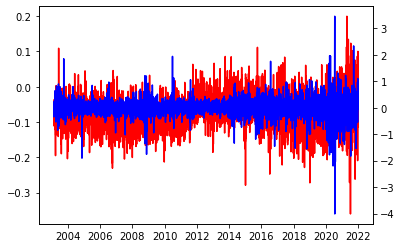

In [49]:
x = newdf.index
y1 = newdf['compound_score']
y2 = newdf['movement']

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
curve1 = ax1.plot(x, y1, label = 'Compound score', color='r')
curve2 = ax2.plot(x, y2, label = 'Stock movement', color='b')

plt.plot()
plt.savefig('AZN&Score')
plt.show()

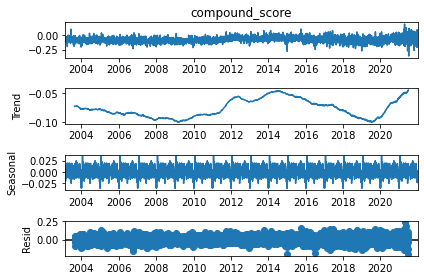

In [50]:
seasonal_decompose=sm.tsa.seasonal_decompose(newdf['compound_score'],model='add',period=365);
fig=seasonal_decompose.plot()
fig.set_figheight(4)
plt.savefig('DecomposeScore')
plt.show()

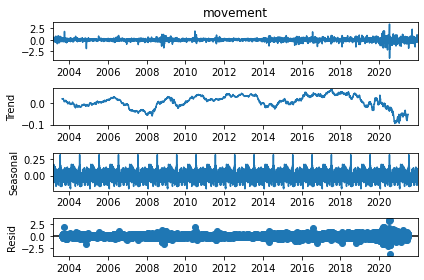

In [51]:
seasonal_decompose=sm.tsa.seasonal_decompose(newdf['movement'],model='add',period=365);
fig=seasonal_decompose.plot()
fig.set_figheight(4)
plt.savefig('DecomposeMovement')
plt.show()

In [52]:
newdf.shape

(6882, 8)

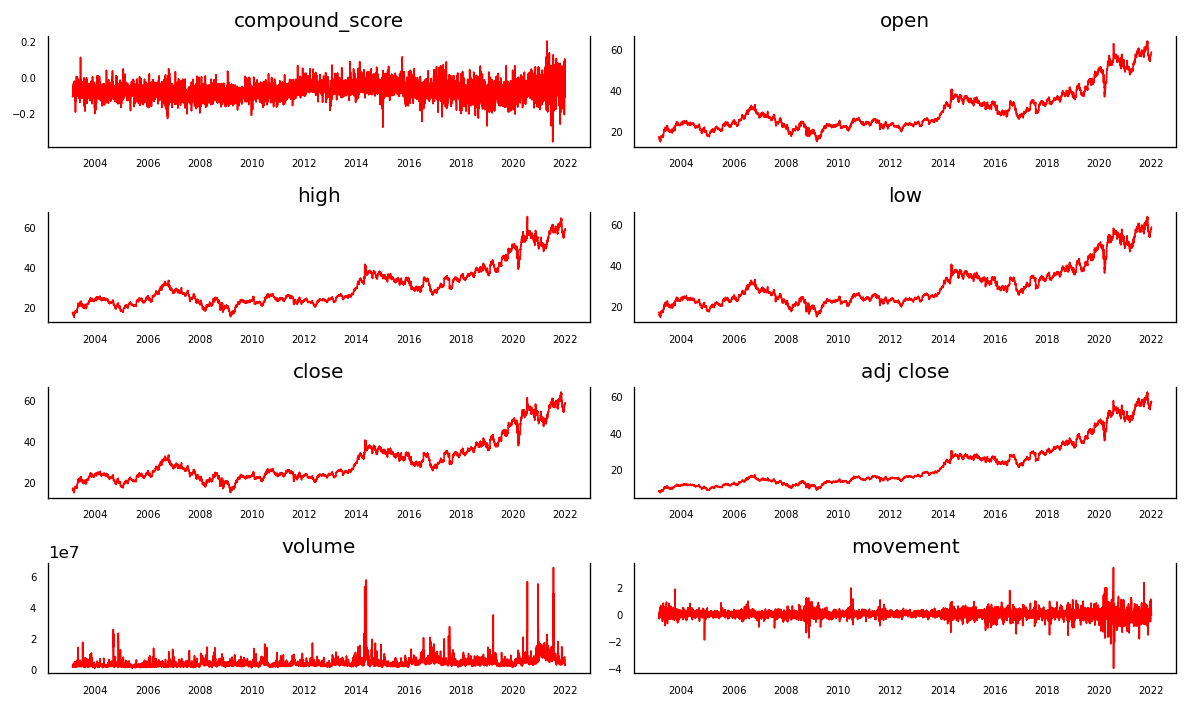

In [53]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = newdf[newdf.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(newdf.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.savefig('NewDFTrend')
plt.tight_layout();

#### Check if data is stationary

In [54]:
adf_cs = adfuller(newdf['compound_score'].diff()[1:])

print(f'ADF Compound score: {adf_cs[0]}')
print(f'p-value Compound score: {adf_cs[1]}')

print('\n---------------------\n')

adf_mm = adfuller(newdf['movement'].diff()[1:])

print(f'ADF Movement: {adf_mm[0]}')
print(f'p-value Movement: {adf_mm[1]}')

ADF Compound score: -23.12875037302023
p-value Compound score: 0.0

---------------------

ADF Movement: -22.576148178743267
p-value Movement: 0.0


### Grange Causality Test and data correlation check

In [55]:
print('Compound score causes Movement?\n')
print('------------------')
granger_1 = grangercausalitytests(newdf[['movement', 'compound_score']], 14)

print('\Movement causes Compound score?\n')
print('------------------')
granger_2 = grangercausalitytests(newdf[['compound_score', 'movement']], 14)

Compound score causes Movement?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8257  , p=0.3635  , df_denom=6878, df_num=1
ssr based chi2 test:   chi2=0.8261  , p=0.3634  , df=1
likelihood ratio test: chi2=0.8260  , p=0.3634  , df=1
parameter F test:         F=0.8257  , p=0.3635  , df_denom=6878, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8090  , p=0.4454  , df_denom=6875, df_num=2
ssr based chi2 test:   chi2=1.6191  , p=0.4451  , df=2
likelihood ratio test: chi2=1.6189  , p=0.4451  , df=2
parameter F test:         F=0.8090  , p=0.4454  , df_denom=6875, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6449  , p=0.5861  , df_denom=6872, df_num=3
ssr based chi2 test:   chi2=1.9366  , p=0.5857  , df=3
likelihood ratio test: chi2=1.9364  , p=0.5857  , df=3
parameter F test:         F=0.6449  , p=0.5861  , df_denom=6872, df_num=3

Granger Causality
number of lags (n

In [56]:
print('Compound score causes Volume?\n')
print('------------------')
granger_1 = grangercausalitytests(newdf[['volume', 'compound_score']], 14)

print('\Volume causes Compound score?\n')
print('------------------')
granger_2 = grangercausalitytests(newdf[['compound_score', 'volume']], 14)

Compound score causes Volume?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.8745  , p=0.0017  , df_denom=6878, df_num=1
ssr based chi2 test:   chi2=9.8788  , p=0.0017  , df=1
likelihood ratio test: chi2=9.8717  , p=0.0017  , df=1
parameter F test:         F=9.8745  , p=0.0017  , df_denom=6878, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.2443  , p=0.0391  , df_denom=6875, df_num=2
ssr based chi2 test:   chi2=6.4933  , p=0.0389  , df=2
likelihood ratio test: chi2=6.4902  , p=0.0390  , df=2
parameter F test:         F=3.2443  , p=0.0391  , df_denom=6875, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.6856  , p=0.0028  , df_denom=6872, df_num=3
ssr based chi2 test:   chi2=14.0712 , p=0.0028  , df=3
likelihood ratio test: chi2=14.0568 , p=0.0028  , df=3
parameter F test:         F=4.6856  , p=0.0028  , df_denom=6872, df_num=3

Granger Causality
number of lags (no 

ssr based F test:         F=2.3829  , p=0.0026  , df_denom=6839, df_num=14
ssr based chi2 test:   chi2=33.5018 , p=0.0024  , df=14
likelihood ratio test: chi2=33.4203 , p=0.0025  , df=14
parameter F test:         F=2.3829  , p=0.0026  , df_denom=6839, df_num=14


In [57]:
print('Compound score causes Closing price?\n')
print('------------------')
granger_1 = grangercausalitytests(newdf[['close', 'compound_score']], 14)

print('\Closing price causes Compound score?\n')
print('------------------')
granger_2 = grangercausalitytests(newdf[['compound_score', 'close']], 14)

Compound score causes Closing price?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0263  , p=0.8713  , df_denom=6878, df_num=1
ssr based chi2 test:   chi2=0.0263  , p=0.8712  , df=1
likelihood ratio test: chi2=0.0263  , p=0.8712  , df=1
parameter F test:         F=0.0263  , p=0.8713  , df_denom=6878, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0486  , p=0.9526  , df_denom=6875, df_num=2
ssr based chi2 test:   chi2=0.0972  , p=0.9525  , df=2
likelihood ratio test: chi2=0.0972  , p=0.9525  , df=2
parameter F test:         F=0.0486  , p=0.9526  , df_denom=6875, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0770  , p=0.9725  , df_denom=6872, df_num=3
ssr based chi2 test:   chi2=0.2311  , p=0.9724  , df=3
likelihood ratio test: chi2=0.2311  , p=0.9724  , df=3
parameter F test:         F=0.0770  , p=0.9725  , df_denom=6872, df_num=3

Granger Causality
number of la

In [58]:
print('Volume causes Movement?\n')
print('------------------')
granger_1 = grangercausalitytests(newdf[['movement', 'volume']], 14)

print('\Movement causes Volume?\n')
print('------------------')
granger_2 = grangercausalitytests(newdf[['volume', 'movement']], 14)

Volume causes Movement?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9338  , p=0.3339  , df_denom=6878, df_num=1
ssr based chi2 test:   chi2=0.9342  , p=0.3338  , df=1
likelihood ratio test: chi2=0.9342  , p=0.3338  , df=1
parameter F test:         F=0.9338  , p=0.3339  , df_denom=6878, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6668  , p=0.5134  , df_denom=6875, df_num=2
ssr based chi2 test:   chi2=1.3346  , p=0.5131  , df=2
likelihood ratio test: chi2=1.3344  , p=0.5131  , df=2
parameter F test:         F=0.6668  , p=0.5134  , df_denom=6875, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2333  , p=0.2958  , df_denom=6872, df_num=3
ssr based chi2 test:   chi2=3.7037  , p=0.2953  , df=3
likelihood ratio test: chi2=3.7027  , p=0.2954  , df=3
parameter F test:         F=1.2333  , p=0.2958  , df_denom=6872, df_num=3

Granger Causality
number of lags (no zero) 

In [59]:
print('Volume causes Price?\n')
print('------------------')
granger_1 = grangercausalitytests(newdf[['close', 'volume']], 14)

print('\Price causes Volume?\n')
print('------------------')
granger_2 = grangercausalitytests(newdf[['volume', 'close']], 14)

Volume causes Price?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0260  , p=0.8719  , df_denom=6878, df_num=1
ssr based chi2 test:   chi2=0.0260  , p=0.8719  , df=1
likelihood ratio test: chi2=0.0260  , p=0.8719  , df=1
parameter F test:         F=0.0260  , p=0.8719  , df_denom=6878, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0485  , p=0.9526  , df_denom=6875, df_num=2
ssr based chi2 test:   chi2=0.0972  , p=0.9526  , df=2
likelihood ratio test: chi2=0.0972  , p=0.9526  , df=2
parameter F test:         F=0.0485  , p=0.9526  , df_denom=6875, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0586  , p=0.3654  , df_denom=6872, df_num=3
ssr based chi2 test:   chi2=3.1791  , p=0.3648  , df=3
likelihood ratio test: chi2=3.1784  , p=0.3649  , df=3
parameter F test:         F=1.0586  , p=0.3654  , df_denom=6872, df_num=3

Granger Causality
number of lags (no zero) 4
s

<AxesSubplot:>

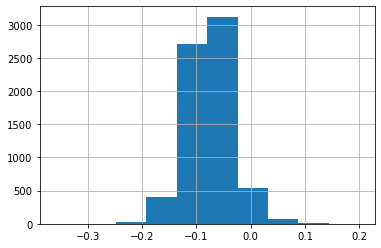

In [60]:
newdf['compound_score'].hist()

<AxesSubplot:>

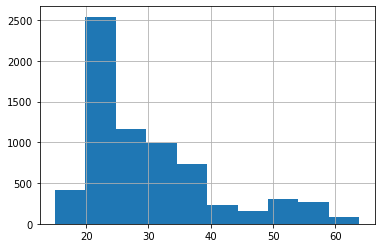

In [61]:
newdf['close'].hist()

<AxesSubplot:>

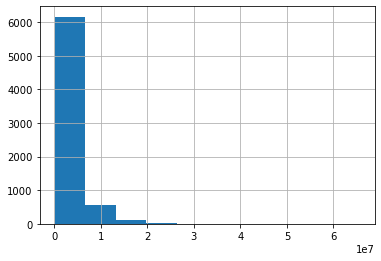

In [62]:
newdf['volume'].hist()

<AxesSubplot:>

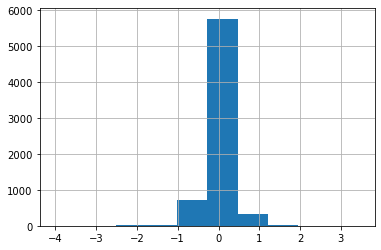

In [63]:
newdf['movement'].hist()

In [64]:
newdf.shape

(6882, 8)

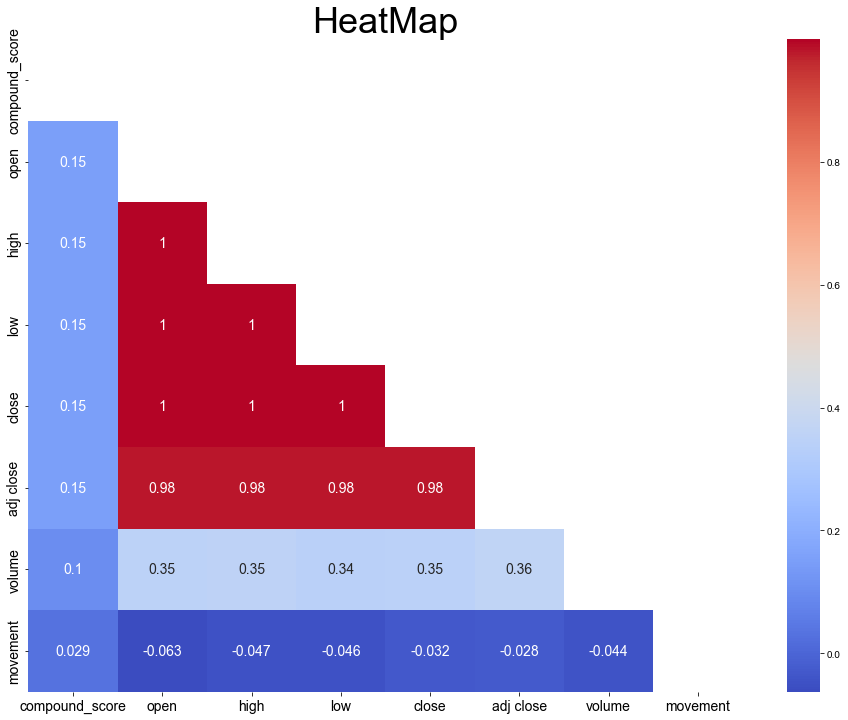

In [65]:
##HeatMap to Verify Multicollinearity between Features
fig = plt.figure(figsize=(16,12))
matrix = np.triu(newdf.corr())
ax = sns.heatmap(newdf.corr(),annot=True,annot_kws={"size":14},mask=matrix,cmap='coolwarm')
ax.tick_params(labelsize=14)
sns.set(font_scale=3)
ax.set_title('HeatMap')
plt.style.use('fivethirtyeight')
plt.savefig('FeaturesCorrelation')
plt.show()

In [66]:
newdf.head()

,compound_score,open,high,low,close,adj close,volume,movement
date,,,,,,,,
2003-02-19,-0.107614,17.350,17.350000,17.049999,17.205000,8.077115,1593400,-0.145000
2003-02-20,-0.110760,17.225,17.275000,16.995001,17.219999,8.084159,919000,-0.005001
2003-02-21,-0.104719,17.225,17.424999,16.850000,17.215000,8.081808,1477800,-0.010000
2003-02-22,-0.052789,17.225,17.424999,16.850000,17.215000,8.081808,1477800,-0.010000
2003-02-23,-0.099331,17.225,17.424999,16.850000,17.215000,8.081808,1477800,-0.010000


In [67]:
newdf.shape

(6882, 8)

In [68]:
# preparing the dataset by shifting the movement by 1
steps=-1
data= newdf.copy()
data['actual']=data['movement'].shift(steps)
data.head(3)

,compound_score,open,high,low,close,adj close,volume,movement,actual
date,,,,,,,,,
2003-02-19,-0.107614,17.350,17.350000,17.049999,17.205000,8.077115,1593400,-0.145000,-0.005001
2003-02-20,-0.110760,17.225,17.275000,16.995001,17.219999,8.084159,919000,-0.005001,-0.010000
2003-02-21,-0.104719,17.225,17.424999,16.850000,17.215000,8.081808,1477800,-0.010000,-0.010000


In [69]:
data.tail()

,compound_score,open,high,low,close,adj close,volume,movement,actual
date,,,,,,,,,
2021-12-27,-0.114184,57.619999,58.070000,57.529999,58.060001,56.714771,2170800,0.440002,0.259999
2021-12-28,-0.052474,58.060001,58.490002,58.060001,58.320000,56.968746,2188700,0.259999,0.190003
2021-12-29,0.006050,58.459999,58.689999,58.310001,58.650002,57.291100,2716500,0.190003,-0.059998
2021-12-30,0.016529,58.529999,58.880001,58.340000,58.470001,57.115269,2183700,-0.059998,-0.059998
2021-12-31,0.008130,58.529999,58.880001,58.340000,58.470001,57.115269,2183700,-0.059998,NaN


In [70]:
data = data.dropna()

In [71]:
data.tail()

,compound_score,open,high,low,close,adj close,volume,movement,actual
date,,,,,,,,,
2021-12-26,0.100444,57.500000,57.910000,57.360001,57.639999,56.304501,3473600,0.139999,0.440002
2021-12-27,-0.114184,57.619999,58.070000,57.529999,58.060001,56.714771,2170800,0.440002,0.259999
2021-12-28,-0.052474,58.060001,58.490002,58.060001,58.320000,56.968746,2188700,0.259999,0.190003
2021-12-29,0.006050,58.459999,58.689999,58.310001,58.650002,57.291100,2716500,0.190003,-0.059998
2021-12-30,0.016529,58.529999,58.880001,58.340000,58.470001,57.115269,2183700,-0.059998,-0.059998


In [72]:
newset = data[['compound_score', 'movement', 'actual']]

In [73]:
newset

,compound_score,movement,actual
date,,,
2003-02-19,-0.107614,-0.145000,-0.005001
2003-02-20,-0.110760,-0.005001,-0.010000
2003-02-21,-0.104719,-0.010000,-0.010000
2003-02-22,-0.052789,-0.010000,-0.010000
2003-02-23,-0.099331,-0.010000,-0.350000
...,...,...,...
2021-12-26,0.100444,0.139999,0.440002
2021-12-27,-0.114184,0.440002,0.259999
2021-12-28,-0.052474,0.259999,0.190003


## 6. Modelling

### Data split for modelling

In [74]:
exo = newset[['compound_score', 'movement']]
exotest = exo[6517:]
exotest.shape

(364, 2)

In [75]:
newset_train = newset[:6517]
newset_test = newset[6517:]
#Testing period Jan21 - Dec21

In [76]:
print('train: ', newset_train.shape, '  ', 'test: ', newset_test.shape)

train:  (6517, 3)    test:  (364, 3)


### Normalizing input and output features

In [77]:
sc_input = MinMaxScaler(feature_range=(-1, 1))
scaled_input = sc_input.fit_transform(newset_train[['compound_score', 'movement']])
scaled_input =pd.DataFrame(scaled_input)
Xsc= scaled_input

In [78]:
Xsc

,0,1
0,-0.122071,3.619346e-02
1,-0.138161,7.372673e-02
2,-0.107268,7.238651e-02
3,0.158329,7.238651e-02
4,-0.079709,7.238651e-02
...,...,...
6512,0.073985,-2.680980e-02
6513,0.157473,-1.528144e-01
6514,-0.188362,-1.286855e-01
6515,0.417217,6.702417e-07


In [79]:
Xsc.rename(columns={0: 'compound_score', 1: 'movement'}, inplace=True)
Xsc = pd.DataFrame(Xsc)
Xsc.index = newset_train.index
Xsc.tail(5)

,compound_score,movement
date,,
2020-12-27,0.073985,-2.680980e-02
2020-12-28,0.157473,-1.528144e-01
2020-12-29,-0.188362,-1.286855e-01
2020-12-30,0.417217,6.702417e-07
2020-12-31,0.515365,7.238705e-02


In [80]:
Xsc.head(5)

,compound_score,movement
date,,
2003-02-19,-0.122071,0.036193
2003-02-20,-0.138161,0.073727
2003-02-21,-0.107268,0.072387
2003-02-22,0.158329,0.072387
2003-02-23,-0.079709,0.072387


In [81]:
sc_output = MinMaxScaler(feature_range=(-1, 1))
scaler_output = sc_output.fit_transform(newset_train[['actual']])
scaler_output =pd.DataFrame(scaler_output)
ysc=scaler_output

In [82]:
ysc.head()

,0
0,0.073727
1,0.072387
2,0.072387
3,0.072387
4,-0.018766


In [83]:
ysc.rename(columns={0:'actual'}, inplace= True)
ysc.index=newset_train.index
ysc.head(2)

,actual
date,
2003-02-19,0.073727
2003-02-20,0.072387


In [84]:
train_size=int(len(newset_train) *0.80)
test_size = int(len(newset_train)) - train_size
print(test_size)

1304


In [85]:
X_train, y_train = Xsc[:train_size], ysc[:train_size]
X_test, y_test = Xsc[train_size:], ysc[train_size:]

In [86]:
X_test.columns

Index(['compound_score', 'movement'], dtype='object')

In [87]:
y_test.shape

(1304, 1)

In [88]:
X_test.shape

(1304, 2)

### ACT&PACF Correlograms

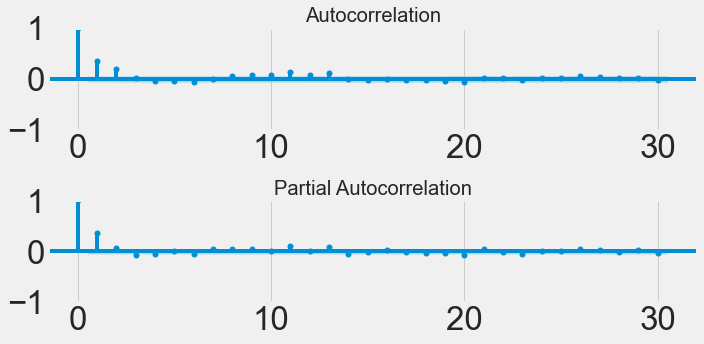

In [89]:
fig,ax= plt.subplots(2,1, figsize=(10,5))
fig=sm.tsa.graphics.plot_acf(y_test, lags=30, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(y_test, lags=30, ax=ax[1])
plt.savefig('ACF&PACF')
plt.tight_layout();

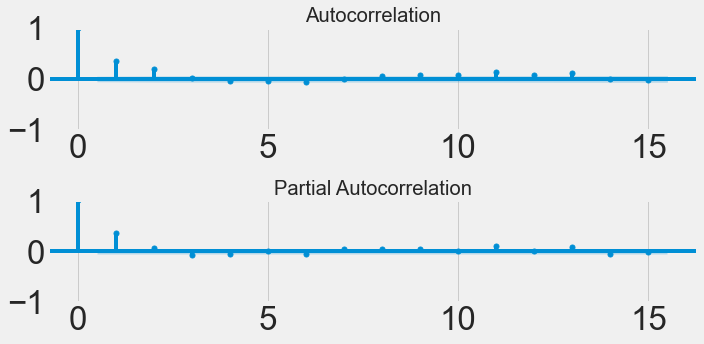

In [90]:
fig,ax= plt.subplots(2,1, figsize=(10,5))
fig=sm.tsa.graphics.plot_acf(y_test, lags=15, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(y_test, lags=15, ax=ax[1])
plt.tight_layout();

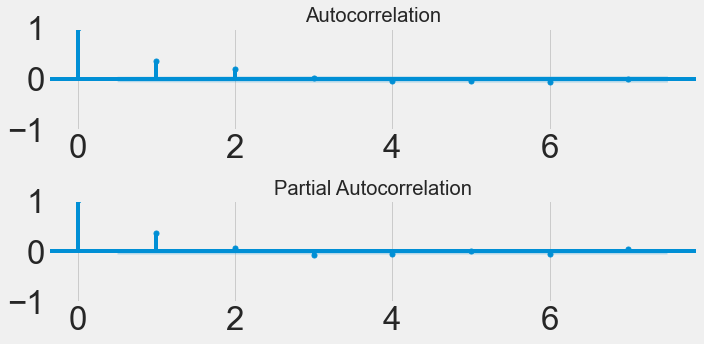

In [91]:
fig,ax= plt.subplots(2,1, figsize=(10,5))
fig=sm.tsa.graphics.plot_acf(y_test, lags=7, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(y_test, lags=7, ax=ax[1])
plt.tight_layout();

### Serching for best model

In [92]:
ar=auto_arima(ysc, 
                     exogenous= Xsc,
                     start_p=1,  start_q=1, 
                     max_p=7,  max_q=7, 
                     d=1, max_d=7,
                     trace=True, 
                     error_action='ignore', 
                     suppress_warnings=True, 
                     stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=6.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-13474.127, Time=0.78 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-13562.240, Time=1.83 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=6.39 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-13476.127, Time=1.33 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-13907.322, Time=2.34 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-14008.580, Time=3.46 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-14212.854, Time=5.31 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-14284.107, Time=4.24 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=-14467.177, Time=6.55 sec
 ARIMA(7,1,0)(0,0,0)[0] intercept   : AIC=-14531.803, Time=12.01 sec
 ARIMA(7,1,1)(0,0,0)[0] intercept   : AIC=-14869.887, Time=11.12 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=-14877.626, Time=10.54 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-14902.078, Time=9.06 sec
 ARIMA(4,1,1)(0,

In [93]:
ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 6517
Model:               SARIMAX(2, 1, 2)   Log Likelihood                7525.072
Date:                Sat, 22 Oct 2022   AIC                         -15034.144
Time:                        06:35:02   BIC                         -14979.888
Sample:                             0   HQIC                        -15015.381
                               - 6517                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept      -1.166e-05   2.34e-05     -0.499      0.618   -5.75e-05    3.42e-05
compound_score    -0.0010      0.002     -0.468      0.640      -0.005       0.003
movement          -0.9026      0.154     -5.879      0.000      -1.204      -0.602
ar.L1              0.3295      0.008     40.850      0.000       0.314       0.345
ar.L2              0.0555      0.007      7.953      0.000       0.042       0.069
ma.L1             -0.0896      0.157     -0.570      0.569      -0.398       0.218
ma.L2             -0.8869      0.155     -5.706      0.000      -1.192      -0.582
sigma2             0.0058    3.2e-05    181.601      0.000       0.006       0.006
===================================================================================
Ljung-Box (L1) (Q):                   2.09   Jarque-Bera (JB):            253416.02
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               3.12   Skew:                            -0.96
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Fitting the model with best order

In [94]:
model= SARIMAX(ysc, 
           exog=Xsc,
              order=(2,1,2),
              enforce_invertibility=False, enforce_stationarity=False)

In [95]:
results = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.13162D+00    |proj g|=  9.37274D-01


 This problem is unconstrained.



At iterate    5    f= -1.13858D+00    |proj g|=  7.51554D-01

At iterate   10    f= -1.15394D+00    |proj g|=  1.27860D-01

At iterate   15    f= -1.15505D+00    |proj g|=  3.35191D-02

At iterate   20    f= -1.15510D+00    |proj g|=  1.57702D-02

At iterate   25    f= -1.15582D+00    |proj g|=  8.78658D-02

At iterate   30    f= -1.15677D+00    |proj g|=  2.27263D-02

At iterate   35    f= -1.15695D+00    |proj g|=  5.88858D-03

At iterate   40    f= -1.15718D+00    |proj g|=  1.86673D-01

At iterate   45    f= -1.15778D+00    |proj g|=  5.12518D-02

At iterate   50    f= -1.15785D+00    |proj g|=  7.08504D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

### Model prediction

In [96]:
pred= results.predict(start =train_size, end=train_size+test_size+(steps),exog=exotest)
print(len(pred))

1304


In [97]:
pred

date
2017-06-06    0.072653
2017-06-07    0.105149
2017-06-08    0.067104
2017-06-09    0.052912
2017-06-10    0.056778
                ...   
2020-12-27    0.038246
2020-12-28   -0.002682
2020-12-29   -0.005294
2020-12-30    0.038133
2020-12-31    0.075567
Name: predicted_mean, Length: 1304, dtype: float64

In [98]:
act= pd.DataFrame(scaler_output.iloc[train_size:, 0])

In [99]:
act

,actual
date,
2017-06-06,1.340490e-01
2017-06-07,2.144814e-02
2017-06-08,1.608594e-02
2017-06-09,1.608594e-02
2017-06-10,1.608594e-02
...,...
2020-12-27,-1.528144e-01
2020-12-28,-1.286855e-01
2020-12-29,6.702417e-07


In [100]:
preds = pd.DataFrame(pred)
preds.reset_index(drop=True, inplace=True)
preds.index=X_test.index
preds['actual'] =act['actual']


In [101]:
preds.columns

Index(['predicted_mean', 'actual'], dtype='object')

In [102]:
preds.rename(columns={'predicted_mean':'pred', 'actual':'actual'}, inplace=True)

In [103]:
preds

,pred,actual
date,,
2017-06-06,0.072653,1.340490e-01
2017-06-07,0.105149,2.144814e-02
2017-06-08,0.067104,1.608594e-02
2017-06-09,0.052912,1.608594e-02
2017-06-10,0.056778,1.608594e-02
...,...,...
2020-12-27,0.038246,-1.528144e-01
2020-12-28,-0.002682,-1.286855e-01
2020-12-29,-0.005294,6.702417e-07


In [104]:
preds.to_csv('ARIMAwithSentimentScore.csv')

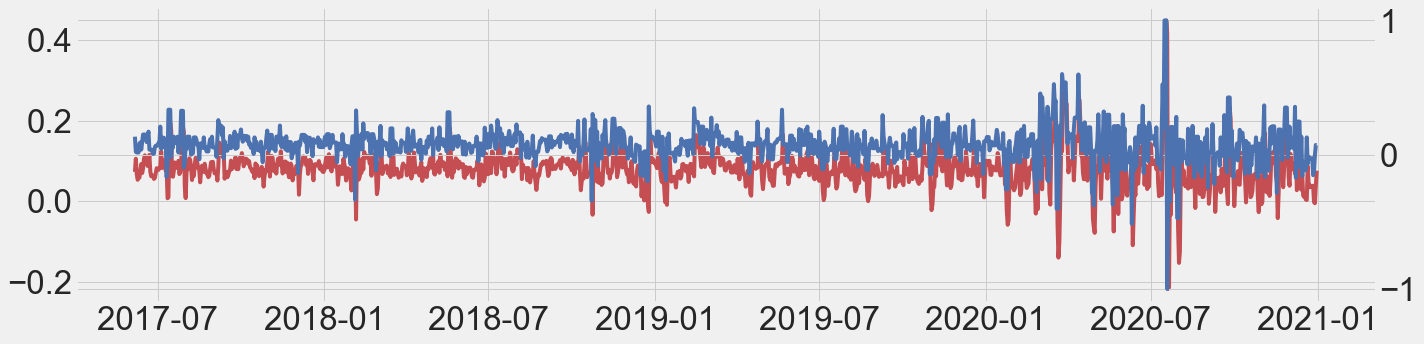

In [105]:
x = X_test.index
y1 = preds['pred']
y2 = preds['actual']

fig, ax1 = plt.subplots(figsize=(20,5))
ax2 = ax1.twinx()
curve1 = ax1.plot(x, y1, label = 'Prediction', color='r')
curve2 = ax2.plot(x, y2, label = 'Actual', color='b')

plt.savefig('ARIMA&CompoundScore')
plt.tight_layout();


### Model valuation on test set

In [106]:
error = rmse(preds['pred'], preds['actual'])

In [107]:
print('RMSE: ', error)

RMSE:  0.12090509046629


### Model prediction on unseen set

In [108]:
newset_test

,compound_score,movement,actual
date,,,
2021-01-01,-0.114374,-0.009998,-0.009998
2021-01-02,0.050722,-0.009998,-0.009998
2021-01-03,-0.059979,-0.009998,-0.399998
2021-01-04,-0.048658,-0.399998,0.299999
2021-01-05,-0.030779,0.299999,0.070000
...,...,...,...
2021-12-26,0.100444,0.139999,0.440002
2021-12-27,-0.114184,0.440002,0.259999
2021-12-28,-0.052474,0.259999,0.190003


In [109]:
pred_size = int(len(newset_test))

In [110]:
pred_size

364

In [111]:
Xp = newset_test[['compound_score', 'movement']]
yp = newset_test[['actual']]
X_pred, y_pred = Xp[:pred_size], yp[:pred_size]

In [112]:
Xp.shape

(364, 2)

In [113]:
unseen= results.predict(start = len(newset_train), end=len(newset_train)+len(newset_test)-1, exog=Xp)

In [114]:
unseen

6517    0.105412
6518    0.102334
6519    0.100166
6520    0.215060
6521    0.004147
          ...   
6876    0.050880
6877   -0.037749
6878    0.015833
6879    0.036461
6880    0.111332
Name: predicted_mean, Length: 364, dtype: float64

In [115]:
forecast = pd.DataFrame(unseen)
forecast.reset_index(drop=True, inplace=True)
forecast.index=newset_test.index
forecast

,predicted_mean
date,
2021-01-01,0.105412
2021-01-02,0.102334
2021-01-03,0.100166
2021-01-04,0.215060
2021-01-05,0.004147
...,...
2021-12-26,0.050880
2021-12-27,-0.037749
2021-12-28,0.015833


In [116]:
forecast['actual'] =yp['actual']

In [117]:
forecast.rename(columns={'predicted_mean':'forecast', 'actual':'actual'}, inplace=True)

In [118]:
forecast

,forecast,actual
date,,
2021-01-01,0.105412,-0.009998
2021-01-02,0.102334,-0.009998
2021-01-03,0.100166,-0.399998
2021-01-04,0.215060,0.299999
2021-01-05,0.004147,0.070000
...,...,...
2021-12-26,0.050880,0.440002
2021-12-27,-0.037749,0.259999
2021-12-28,0.015833,0.190003


In [119]:
forecast.to_csv('ForecastUnseen.csv')

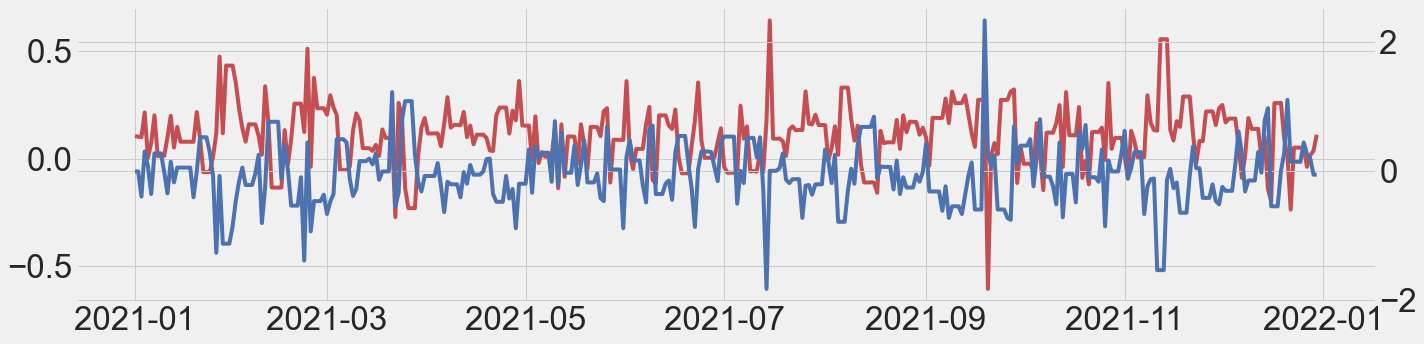

In [120]:
x = newset_test.index
y1 = forecast['forecast']
y2 = forecast['actual']

fig, ax1 = plt.subplots(figsize=(20,5))
ax2 = ax1.twinx()
curve1 = ax1.plot(x, y1, label = 'Forecast', color='r')
curve2 = ax2.plot(x, y2, label = 'Actual', color='b')

plt.savefig('ARIMA&CompoundScoreUnseen')
plt.tight_layout();


### Model valuation on unseen set

In [121]:
error = rmse(forecast['forecast'], forecast['actual'])
print('RMSE: ', error)

RMSE:  0.5649857337113736


## Modelling without Sentiment score

In [122]:
az = newset[['movement', 'actual']]
az

,movement,actual
date,,
2003-02-19,-0.145000,-0.005001
2003-02-20,-0.005001,-0.010000
2003-02-21,-0.010000,-0.010000
2003-02-22,-0.010000,-0.010000
2003-02-23,-0.010000,-0.350000
...,...,...
2021-12-26,0.139999,0.440002
2021-12-27,0.440002,0.259999
2021-12-28,0.259999,0.190003


### Data split

In [123]:
az_train = az[:6517]
az_test = az[6517:]
#Testing period Jan21 - Dec21

In [124]:
print('train: ', az_train.shape, '  ', 'test: ', az_test.shape)

train:  (6517, 2)    test:  (364, 2)


In [125]:
azexotest = az_test[['actual']]

### Normalising input and output feature

In [126]:
azsc_input = MinMaxScaler(feature_range=(-1, 1))
azscaled_input = azsc_input.fit_transform(az_train[['movement']])
azscaled_input =pd.DataFrame(azscaled_input)
Xazsc= azscaled_input

In [127]:
Xazsc

,0
0,3.619346e-02
1,7.372673e-02
2,7.238651e-02
3,7.238651e-02
4,7.238651e-02
...,...
6512,-2.680980e-02
6513,-1.528144e-01
6514,-1.286855e-01
6515,6.702417e-07


In [128]:
Xazsc.rename(columns={0: 'movement'}, inplace=True)
Xazsc = pd.DataFrame(Xazsc)
Xazsc.index = az_train.index
Xazsc.tail(5)

,movement
date,
2020-12-27,-2.680980e-02
2020-12-28,-1.528144e-01
2020-12-29,-1.286855e-01
2020-12-30,6.702417e-07
2020-12-31,7.238705e-02


In [129]:
Xazsc.head(5)

,movement
date,
2003-02-19,0.036193
2003-02-20,0.073727
2003-02-21,0.072387
2003-02-22,0.072387
2003-02-23,0.072387


In [130]:
azsc_output = MinMaxScaler(feature_range=(-1, 1))
azscaler_output = azsc_output.fit_transform(az_train[['actual']])
azscaler_output =pd.DataFrame(azscaler_output)
yazsc=azscaler_output

In [131]:
yazsc.head()

,0
0,0.073727
1,0.072387
2,0.072387
3,0.072387
4,-0.018766


In [132]:
yazsc.rename(columns={0:'actual'}, inplace= True)
yazsc.index=az_train.index
yazsc.head(2)

,actual
date,
2003-02-19,0.073727
2003-02-20,0.072387


In [133]:
aztrain_size=int(len(az_train) *0.80)
aztest_size = int(len(az_train)) - aztrain_size
print(aztest_size)

1304


In [134]:
Xaz_train, yaz_train = Xazsc[:aztrain_size], yazsc[:aztrain_size]
Xaz_test, yaz_test = Xazsc[aztrain_size:], yazsc[aztrain_size:]

### ACT&PACF Correlograms

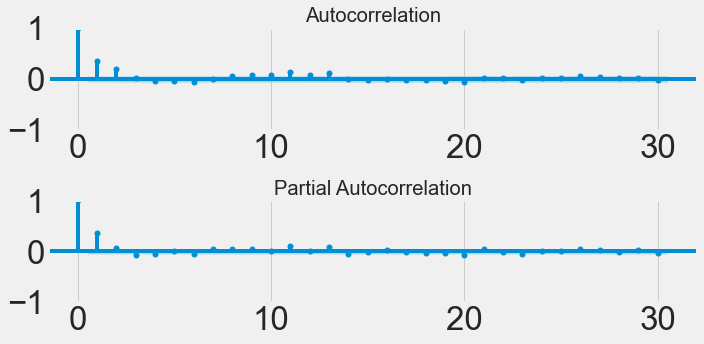

In [135]:
fig,ax= plt.subplots(2,1, figsize=(10,5))
fig=sm.tsa.graphics.plot_acf(yaz_test, lags=30, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(yaz_test, lags=30, ax=ax[1])
plt.savefig('ARIMAwithoutScoreACF&PACF')
plt.tight_layout();

### Searching for best model

In [136]:
araz=auto_arima(yazsc, 
                     exogenous= Xazsc,
                     start_p=1,  start_q=1, 
                     max_p=7,  max_q=7, 
                     d=1, max_d=7,
                     trace=True, 
                     error_action='ignore', 
                     suppress_warnings=True, 
                     stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-14954.372, Time=3.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-13474.024, Time=0.65 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-13562.287, Time=1.77 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=3.76 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-13476.024, Time=0.90 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-15019.905, Time=5.45 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-13907.989, Time=1.83 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-15055.374, Time=6.33 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-14009.075, Time=2.45 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-14861.811, Time=7.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-15009.409, Time=6.27 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=6.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-14212.953, Time=4.46 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-15022.844, Time=7.90 sec
 ARIMA(3,1,1)(0,0,0

In [137]:
araz.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 6517
Model:               SARIMAX(3, 1, 1)   Log Likelihood                7534.687
Date:                Sat, 22 Oct 2022   AIC                         -15055.374
Time:                        06:38:55   BIC                         -15007.900
Sample:                             0   HQIC                        -15038.956
                               - 6517                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.053e-05   1.16e-05     -0.908      0.364   -3.33e-05    1.22e-05
movement      -0.3536      0.049     -7.250      0.000      -0.449      -0.258
ar.L1          0.6693      0.049     13.655      0.000       0.573       0.765
ar.L2         -0.1122      0.048     -2.320      0.020      -0.207      -0.017
ar.L3         -0.0193      0.021     -0.918      0.358      -0.060       0.022
ma.L1         -0.9882      0.002   -519.497      0.000      -0.992      -0.984
sigma2         0.0057   3.21e-05    178.177      0.000       0.006       0.006
===================================================================================
Ljung-Box (L1) (Q):                   0.43   Jarque-Bera (JB):            248609.92
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):               3.10   Skew:                            -0.96
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Fitting the model with best order

In [138]:
azmodel= SARIMAX(yazsc, 
           exog=Xazsc,
              order=(3,1,1),
              enforce_invertibility=False, enforce_stationarity=False)

In [139]:
azresults = azmodel.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.07727D+00    |proj g|=  5.70837D-02

At iterate    5    f= -1.07793D+00    |proj g|=  3.13091D-02

At iterate   10    f= -1.07956D+00    |proj g|=  4.83414D-01

At iterate   15    f= -1.12105D+00    |proj g|=  1.99270D-01

At iterate   20    f= -1.15761D+00    |proj g|=  9.66136D-02

At iterate   25    f= -1.15765D+00    |proj g|=  1.59824D-03

At iterate   30    f= -1.15766D+00    |proj g|=  1.61533D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

### Model prediction

In [140]:
azpred= azresults.predict(start =aztrain_size, end=aztrain_size+aztest_size+(steps))
print(len(azpred))

1304


In [141]:
azpredict = pd.DataFrame(azpred)

In [142]:
azpredict['actual'] =yazsc['actual']
azpredict

,predicted_mean,actual
date,,
2017-06-06,0.072419,1.340490e-01
2017-06-07,0.102929,2.144814e-02
2017-06-08,0.068461,1.608594e-02
2017-06-09,0.052763,1.608594e-02
2017-06-10,0.057330,1.608594e-02
...,...,...
2020-12-27,0.037602,-1.528144e-01
2020-12-28,-0.002301,-1.286855e-01
2020-12-29,-0.007106,6.702417e-07


In [143]:
azpredict.rename(columns={'predicted_mean':'pred', 'actual':'actual'}, inplace=True)

In [144]:
azpredict

,pred,actual
date,,
2017-06-06,0.072419,1.340490e-01
2017-06-07,0.102929,2.144814e-02
2017-06-08,0.068461,1.608594e-02
2017-06-09,0.052763,1.608594e-02
2017-06-10,0.057330,1.608594e-02
...,...,...
2020-12-27,0.037602,-1.528144e-01
2020-12-28,-0.002301,-1.286855e-01
2020-12-29,-0.007106,6.702417e-07


In [145]:
azpredict.to_csv('ARIMAwithoutSentimentScore.csv')

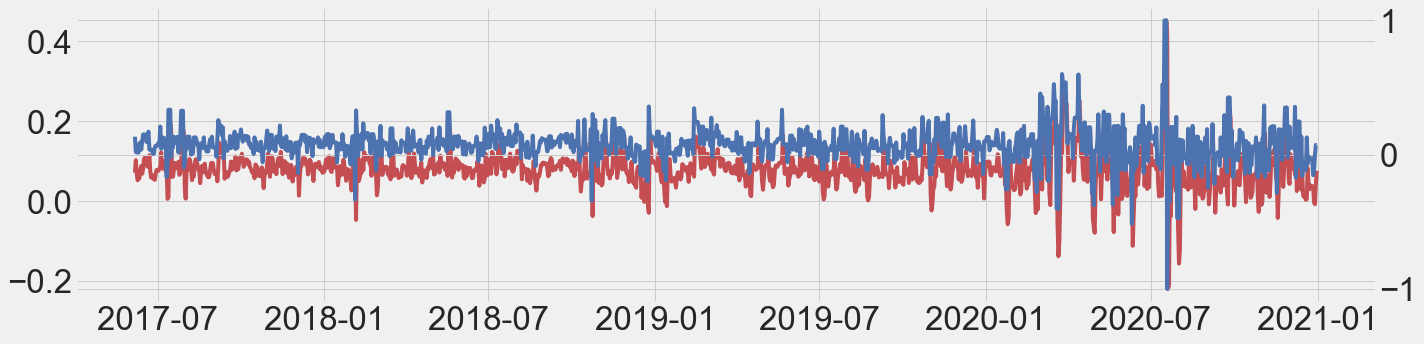

In [146]:
x = azpredict.index
y1 = azpredict['pred']
y2 = azpredict['actual']

fig, ax1 = plt.subplots(figsize=(20,5))
ax2 = ax1.twinx()
curve1 = ax1.plot(x, y1, label = 'Prediction', color='r')
curve2 = ax2.plot(x, y2, label = 'Actual', color='b')

plt.savefig('ARIMAwithoutSentimentScore')
plt.tight_layout();


### Model evaluation on test set

In [147]:
azerror = rmse(azpredict['pred'], azpredict['actual'])
print('RMSE: ', azerror)

RMSE:  0.12096973482288267


### Model prediction on unseen set

In [148]:
az2 = azresults.predict(start = len(az_train), end = len(az_train)+len(az_test)-1, exog=azexotest)

In [149]:
az2

6517    0.086530
6518    0.084323
6519    0.127078
6520    0.047425
6521    0.073011
          ...   
6876    0.031256
6877    0.051517
6878    0.059397
6879    0.087538
6880    0.087538
Name: predicted_mean, Length: 364, dtype: float64

In [150]:
az2 = pd.DataFrame(az2)
az2.reset_index(drop=True, inplace=True)
az2.index=az_test.index
az2

,predicted_mean
date,
2021-01-01,0.086530
2021-01-02,0.084323
2021-01-03,0.127078
2021-01-04,0.047425
2021-01-05,0.073011
...,...
2021-12-26,0.031256
2021-12-27,0.051517
2021-12-28,0.059397


In [151]:
az2['actual'] =az_test['actual']

In [152]:
az2.rename(columns={'predicted_mean':'forecast', 'actual':'actual'}, inplace=True)

In [153]:
az2

,forecast,actual
date,,
2021-01-01,0.086530,-0.009998
2021-01-02,0.084323,-0.009998
2021-01-03,0.127078,-0.399998
2021-01-04,0.047425,0.299999
2021-01-05,0.073011,0.070000
...,...,...
2021-12-26,0.031256,0.440002
2021-12-27,0.051517,0.259999
2021-12-28,0.059397,0.190003


In [154]:
az2.to_csv('ARIMAwithoutSentimentScoreUnseen.csv')

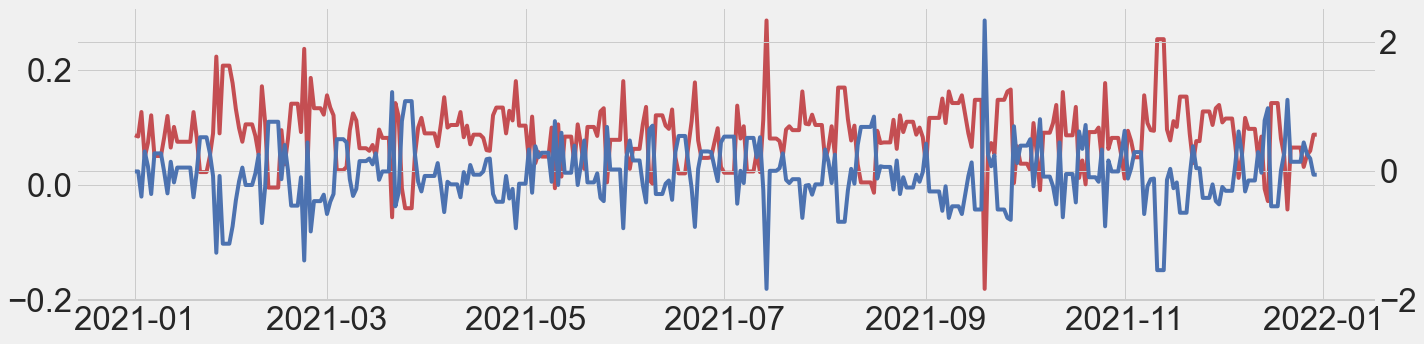

In [155]:
x = az_test.index
y1 = az2['forecast']
y2 = az2['actual']

fig, ax1 = plt.subplots(figsize=(20,5))
ax2 = ax1.twinx()
curve1 = ax1.plot(x, y1, label = 'Prediction', color='r')
curve2 = ax2.plot(x, y2, label = 'Actual', color='b')

plt.savefig('ARIMAwithoutSentimentScoreUnseen')
plt.tight_layout();


### Model evaluation on unseen set

In [156]:
az2error = rmse(az2['forecast'], az2['actual'])

In [157]:
print('RMSE: ', az2error)

RMSE:  0.5425083321524828


# Trading Simulation

### Importing library

In [158]:
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
import warnings

#in practice do not supress these warnings, they carry important information about the status of your model
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=HessianInversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)


### Set up base model

In [159]:
def run_simulation(returns, prices, amt, order, thresh, verbose=False, plot=True):
    if type(order) == float:
        thresh = None
        
    curr_holding = False
    events_list = []
    init_amt = amt

    #go through dates
    for date, r in tqdm (returns.iloc[14:].items(), total=len(returns.iloc[14:])):
        #if you're currently holding the stock, sell it
        if curr_holding:
            sell_price = prices.loc[date]
            curr_holding=False
            ret = (sell_price-buy_price)/buy_price
            amt *= (1+ret)
            events_list.append(('s', date, ret))
            
            if verbose:
                print('Sold at $%s'%sell_price)
                print('Predicted Return: %s'%round(pred,4))
                print('Actual Return: %s'%(round(ret, 4)))
                print('=======================================')
            continue

        #get data til just before current date
        curr_data = returns[:date]
        
        if type(order) == tuple:
            try:
                #fit model
                model = ARIMA(curr_data, order=(3,1,1)).fit(maxiter=200)

                #get forecast
                pred = model.forecast()[0][0]

            except:
                pred = thresh - 1



        #if you predict a high enough return and not holding, buy stock
        if (not curr_holding) and \
        ((type(order) == float and np.random.random() < order) 
         or (type(order) == tuple and pred > thresh)
         or (order == 'last' and curr_data[-1] > 0)):
            
            curr_holding = True
            buy_price = prices.loc[date]
            events_list.append(('b', date))
            if verbose:
                print('Bought at $%s'%buy_price)
                
    if verbose:
        print('Total Amount: $%s'%round(amt,2))
        
    #graph
    if plot:
    
        plt.figure(figsize=(20,10))
        plt.plot(prices[14:])

        y_lims = (int(prices.min()*.95), int(prices.max()*1.05))
        shaded_y_lims = int(prices.min()*.5), int(prices.max()*1.5)

        for idx, event in enumerate(events_list):
            plt.axvline(event[1], color='w', linestyle='--', alpha=0.4)
            if event[0] == 's':
                color = 'green' if event[2] > 0 else 'red'
                plt.fill_betweenx(range(*shaded_y_lims), 
                                  event[1], events_list[idx-1][1], color=color, alpha=0.1)

        tot_return = round(100*(amt / init_amt - 1), 2)
        tot_return = str(tot_return) + '%'
        plt.title("%s Price Data\nThresh=%s\nTotal Amt: $%s\nTotal Return: %s"%(tickerSymbol, thresh, round(amt,2), tot_return), fontsize=20)
        plt.ylim(*y_lims)
        plt.show()
    
    return amt

### Import AZN stock data

In [217]:
tickerSymbol = 'AZN'
data = yf.Ticker(tickerSymbol)

In [218]:
prices = data.history(start='2003-02-19', end='2021-12-30').Close
returns = prices.pct_change().dropna()

Text(0, 0.5, 'Prices')

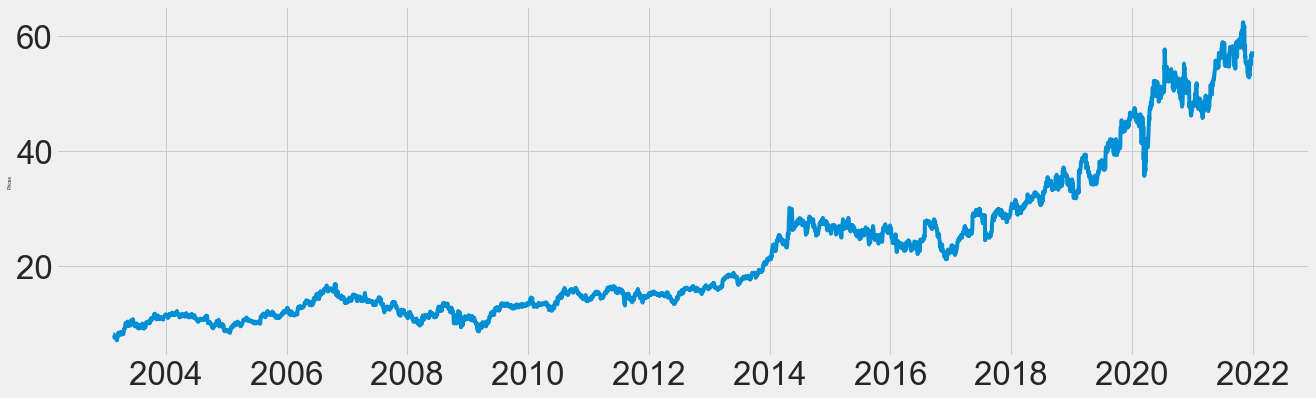

In [219]:
plt.figure(figsize=(20,6))
plt.plot(prices)
plt.ylabel('Prices', fontsize=5)

Text(0, 0.5, 'Return')

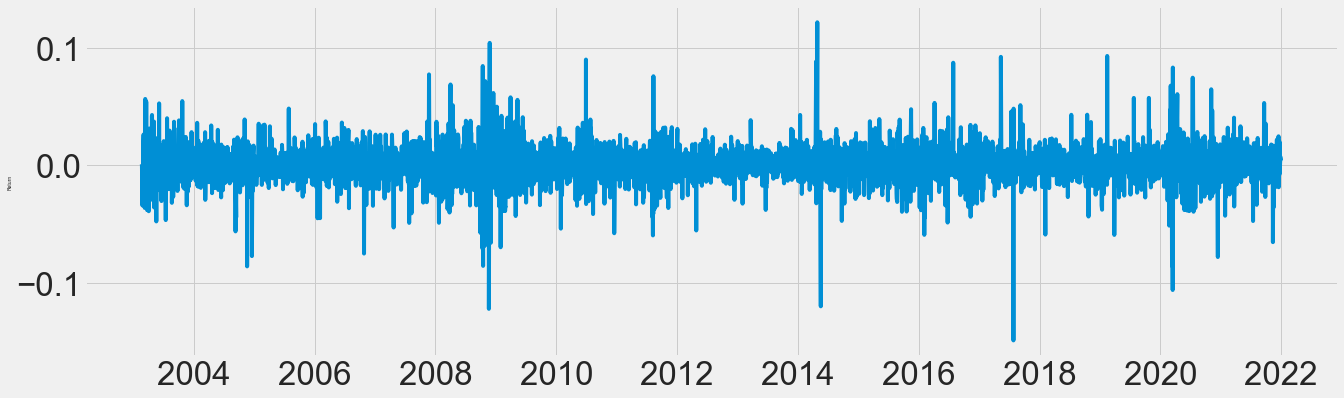

In [220]:
plt.figure(figsize=(20,6))
plt.plot(returns)
plt.ylabel('Return', fontsize=5)

### Base model results for AZN stock

100%|██████████| 4735/4735 [00:00<00:00, 9832.85it/s] 


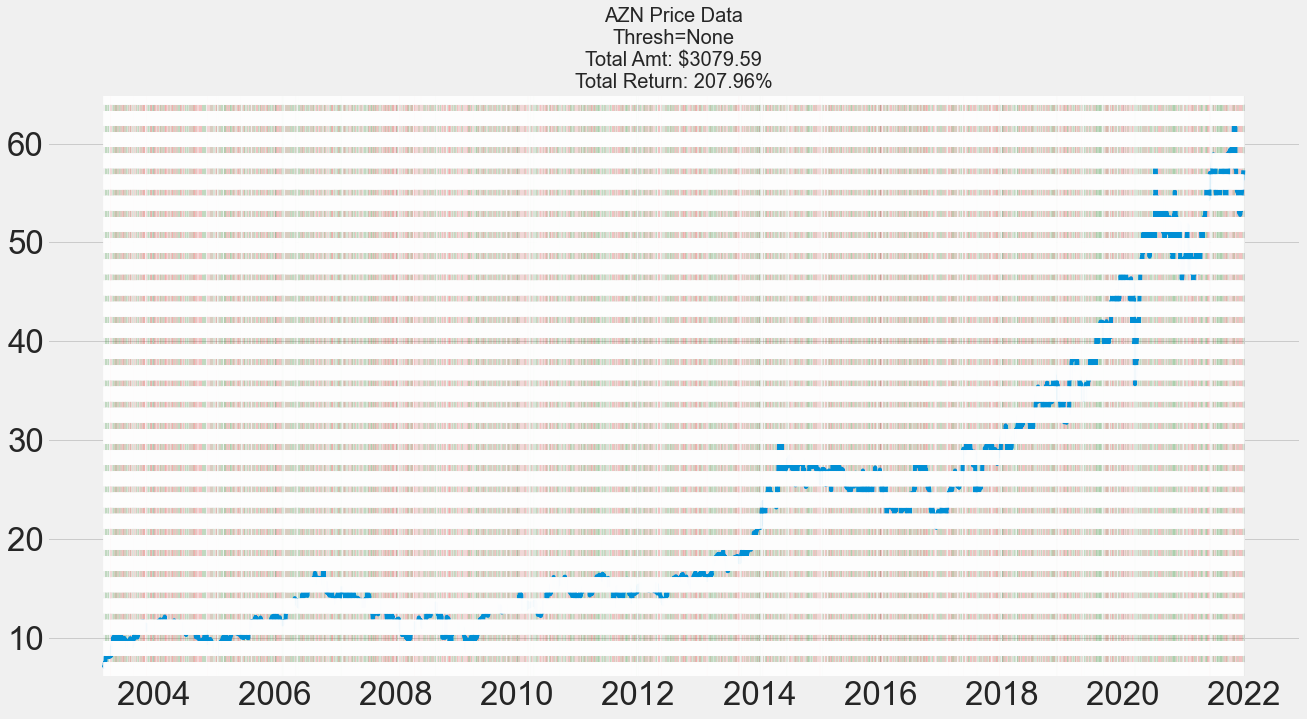

3079.586941067826

In [225]:
run_simulation(returns, prices, 1000, 0.5, None, verbose=False)

### Buy if last return was positive

100%|██████████| 4735/4735 [00:00<00:00, 9347.68it/s]


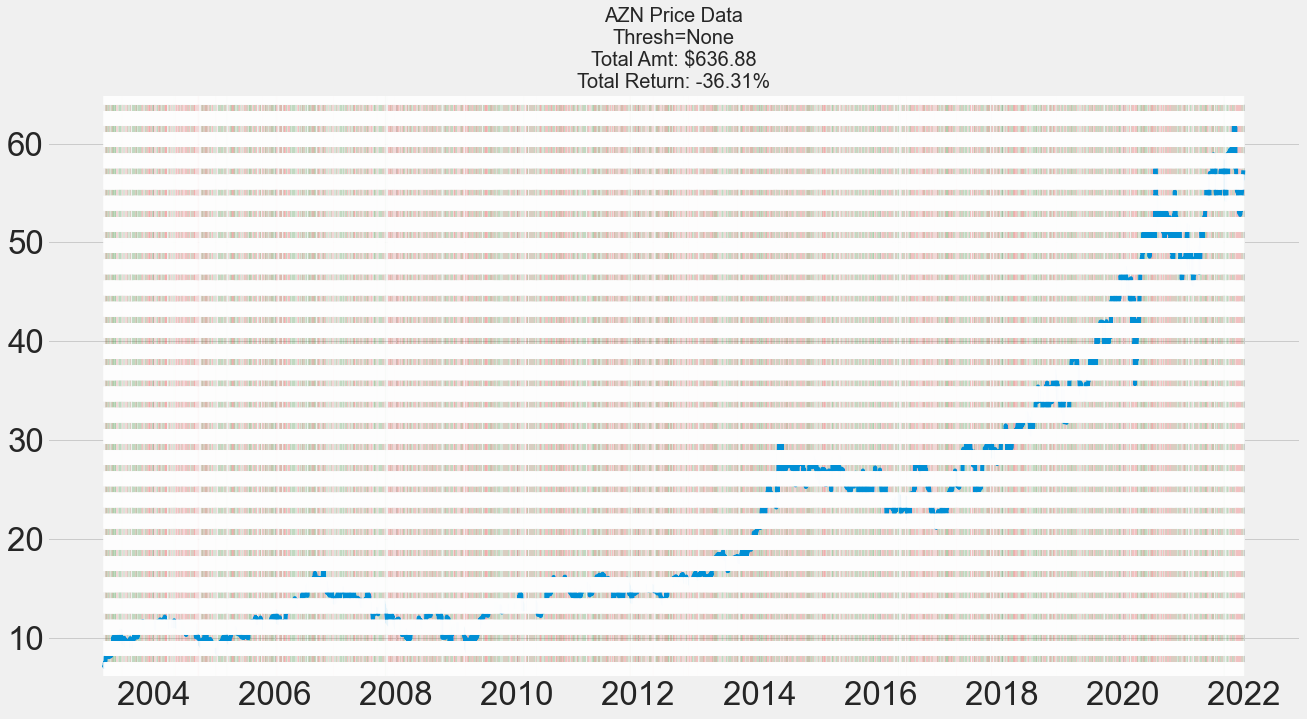

636.8825995279248

In [226]:
run_simulation(returns, prices, 1000, 'last', None, verbose=False)

### Import Qantas stock data

In [227]:
tickerSymbol = 'QAN.AX'
data = yf.Ticker(tickerSymbol)

In [228]:
prices = data.history(start='2003-02-19', end='2021-12-30').Close
returns = prices.pct_change().dropna()

In [229]:
qan_price = prices.copy()

In [230]:
qan_price.to_csv('QANPrices.csv')

Text(0, 0.5, 'Prices')

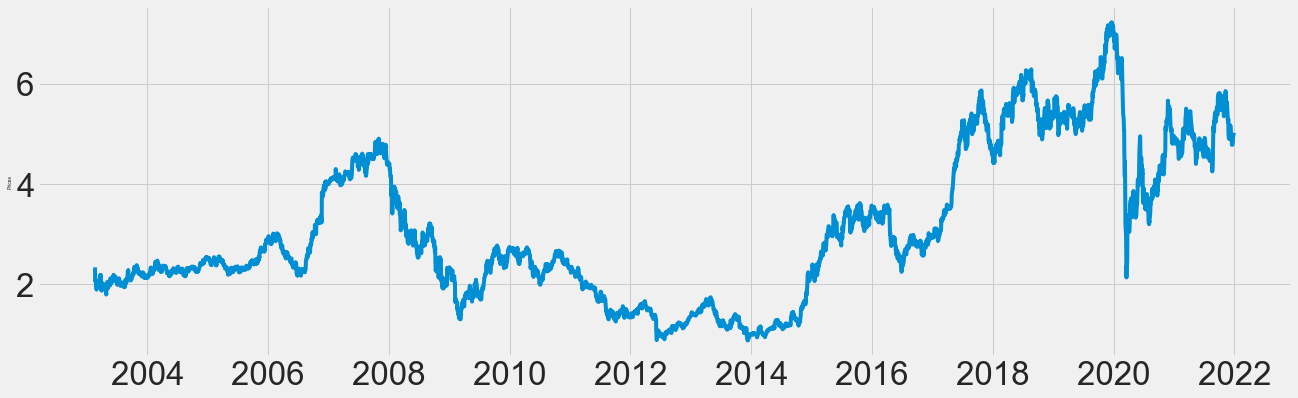

In [231]:
plt.figure(figsize=(20,6))
plt.plot(prices)
plt.ylabel('Prices', fontsize=5)

Text(0, 0.5, 'Return')

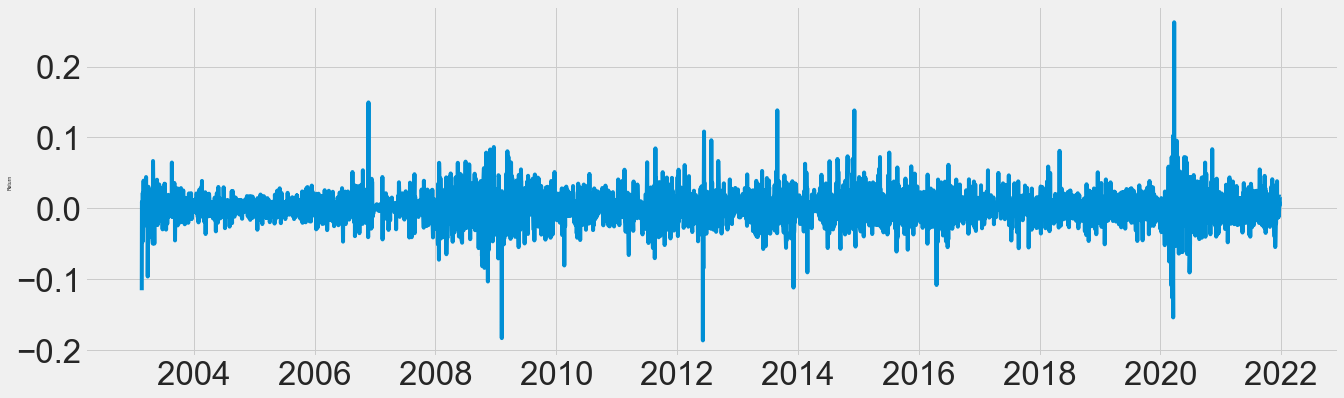

In [232]:
plt.figure(figsize=(20,6))
plt.plot(returns)
plt.ylabel('Return', fontsize=5)

### Base model result for Qantas stock

100%|██████████| 4758/4758 [00:00<00:00, 9518.97it/s]


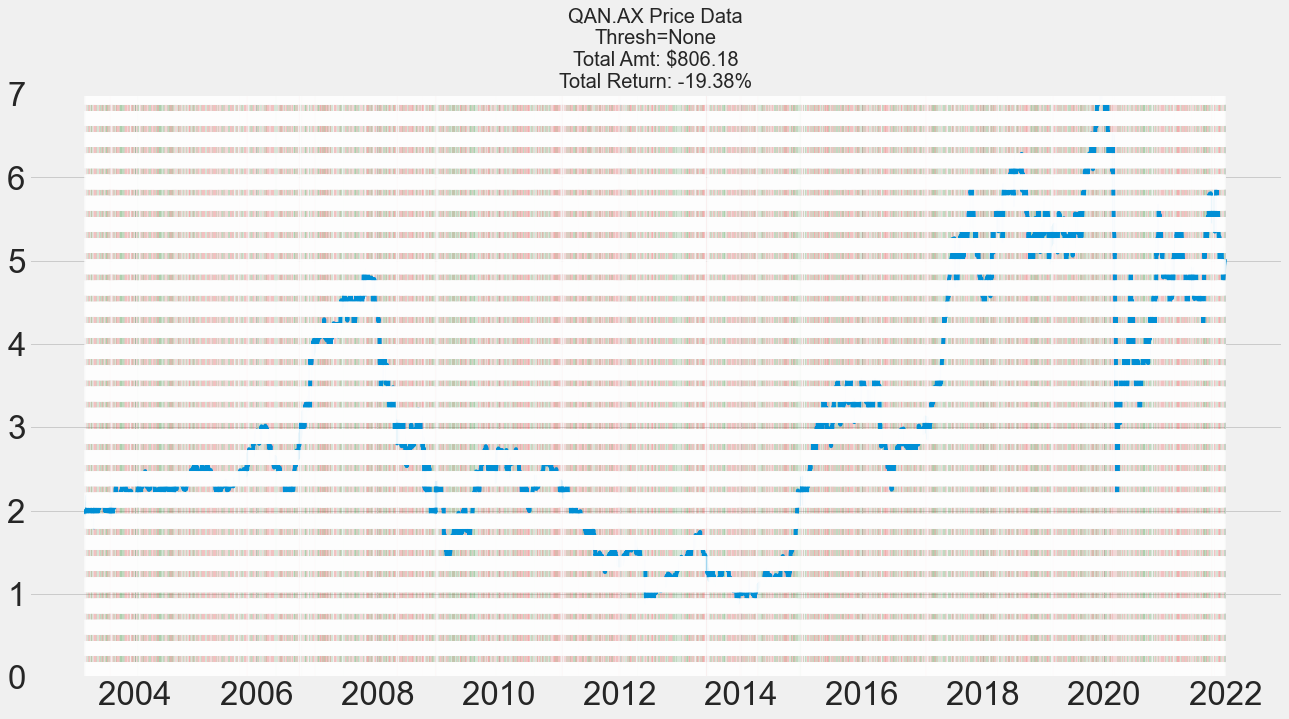

806.1840658791835

In [233]:
run_simulation(returns, prices, 1000, 0.5, None, verbose=False)

### Buy if last return was positive

100%|██████████| 4758/4758 [00:00<00:00, 9149.53it/s]


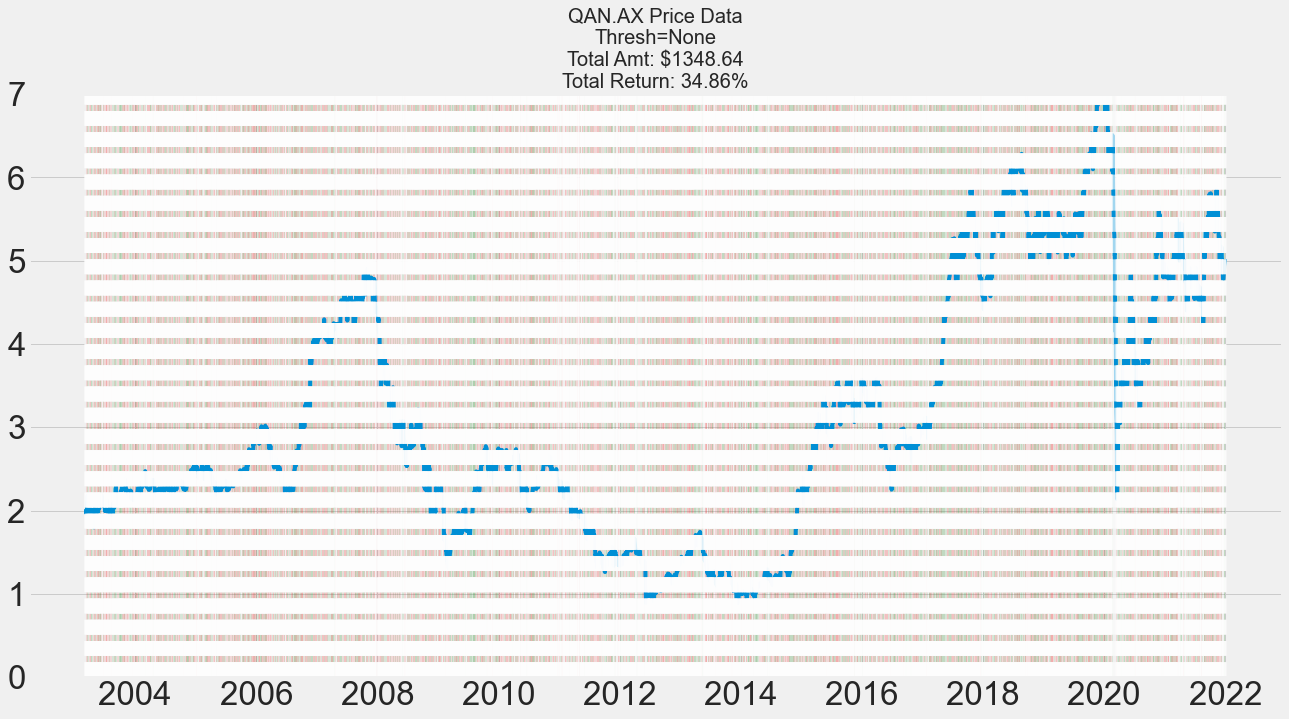

1348.6434642936715

In [234]:
run_simulation(returns, prices, 1000, 'last', None, verbose=False)

## Summary

#### Stock price movement prediction is possible when consider other factors that may have direct and indirect impact to the chosen stock based on its nature, industry and economic impacts around it.

## Next steps

#### 1.	Study technical analysis of market trend
#### 2.	Set up appropriate strategy of your investment plan
#### 3.	Test and set up rules-based strategy that is profitable
#### 4.	Optimise strategy outcome ie stop loss, buying target, risk-reward ratio, and time when the strategy work best
#### 5.	Risk management plan - managing the loss, keep you out of emotion when trade
#### 6.	Practice simulation/demo trading before investing real money
#### 7.	Discipline - don't gamble and stick to the strategy
